In [17]:
import numpy as np
import pandas as pd

file_path= 'Behavioral Data/Survey_Visual_2019-07-23-15-41-47.csv'
data = pd.read_csv(file_path, skiprows=1)  # <-- Skip the first metadata row
data

,Time,Trial,State,Event,Orientation,Position,Velocity,Decoder Output
0,15:40:10.660142,1,BMI Feedback,Session Start,0.0,0.000000,0.00000,False
1,15:40:10.660142,1,BMI Feedback,Trial Start,0.0,0.000000,0.00000,False
2,15:40:34.802698,1,BMI Feedback,Control Applied,0.0,-0.072400,0.00445,True
3,15:40:40.631287,1,BMI Feedback,Control Applied,0.0,0.114850,0.00445,True
4,15:40:42.599799,1,BMI Feedback,Control Applied,0.0,0.313700,0.00445,True
...,...,...,...,...,...,...,...,...
89,15:49:48.103958,16,BMI Feedback,Target Reached,0.0,0.350839,0.00000,False
90,15:49:48.124217,16,Reward,Reward Presented,0.0,0.350839,0.00000,False
91,15:49:50.124807,16,ITI,ITI Start,0.0,0.350839,0.00000,False
92,15:50:08.701573,17,BMI Feedback,Control Applied,0.0,-0.029869,0.00445,True


In [18]:
# Convert time to seconds
def time_to_seconds(time_str):
    """
    Convert time string like '40:10.7' or '01:02:03.456' into seconds.
    """
    parts = time_str.strip().split(':')
    if len(parts) == 3:
        h, m, s = map(float, parts)
        return h * 3600 + m * 60 + s
    elif len(parts) == 2:
        m, s = map(float, parts)
        return m * 60 + s
    else:
        return np.nan
data['Time_sec'] = data['Time'].astype(str).apply(time_to_seconds)

# Calculate the duration of session
total_duration = data['Time_sec'].max() - data['Time_sec'].min()

# Get total number of trials
trial_numbers = data['Trial'].unique()
total_trials = len(trial_numbers)

# Filter successful trials (Event == "Target Reached")
successful_trials = data[data['Event'] == 'Target Reached']
successful_trial_numbers = successful_trials['Trial'].unique()
successful_trials_count = len(successful_trial_numbers)

# Compute reward frequency (successful trials per minute)
reward_frequency = successful_trials_count / (total_duration / 60)

# Calculate duration of each trial
trial_durations = []
for trial in trial_numbers:
    trial_times = data[data['Trial'] == trial]['Time_sec']
    duration = trial_times.max() - trial_times.min()
    trial_durations.append(duration)

average_trial_time = np.mean(trial_durations)
std_trial_time = np.std(trial_durations)

# Print results
print(f"Total experiment duration (seconds): {total_duration:.2f}")
print(f"Total number of trials: {total_trials}")
print(f"Number of successful trials: {successful_trials_count}")
print(f"Reward frequency (rewards per minute): {reward_frequency:.2f}")
print(f"Average trial duration (seconds): {average_trial_time:.2f}")
print(f"Standard deviation of trial durations (seconds): {std_trial_time:.2f}")

Total experiment duration (seconds): 636.80
Total number of trials: 17
Number of successful trials: 15
Reward frequency (rewards per minute): 1.41
Average trial duration (seconds): 18.06
Standard deviation of trial durations (seconds): 16.28


In [19]:
import pandas as pd
import numpy as np
import os

# List of behavioral CSV files
file_names = [
    'Behavioral data/Survey_Visual_2019-07-23-15-41-47.csv','Behavioral data/Survey_Visual_2019-07-23-16-11-36.csv'
    # Add other file names here
]

# Result table will be stored in a list of dictionaries
results = []


In [20]:

for file in file_names:
    try:
        data = pd.read_csv(file, skiprows=1)
        data.columns = data.columns.str.strip().str.lower()

        if not all(col in data.columns for col in ['time', 'trial', 'event']):
            print(f"Skipping {file}: Missing required columns.")
            continue

        data['time_sec'] = data['time'].astype(str).apply(time_to_seconds)

        # Calculate stats
        total_duration = data['time_sec'].max() - data['time_sec'].min()
        trial_numbers = data['trial'].unique()
        total_trials = len(trial_numbers)

        successful_trials = data[data['event'] == 'Target Reached']
        successful_trial_numbers = successful_trials['trial'].unique()
        successful_trials_count = len(successful_trial_numbers)

        successful_rate = successful_trials_count / total_trials if total_trials > 0 else np.nan
        reward_frequency = successful_trials_count / (total_duration / 60) if total_duration > 0 else np.nan

        # Trial durations
        trial_durations = []
        for trial in trial_numbers:
            trial_times = data[data['trial'] == trial]['time_sec']
            duration = trial_times.max() - trial_times.min()
            trial_durations.append(duration)

        average_trial_time = np.mean(trial_durations)
        std_trial_time = np.std(trial_durations)

        results.append({
            'FileName': os.path.basename(file),
            'TotalDuration': total_duration,
            'TotalTrials': total_trials,
            'SuccessfulTrialNumber': successful_trials_count,
            'SuccessfulRate': successful_rate,
            'RewardFrequencyPerMin': reward_frequency,
            'AverageTrialTime': average_trial_time,
            'StdTrialTime': std_trial_time
        })

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv('reward_analysis_results_extended.csv', index=False)

print("Saved results to reward_analysis_results_extended.csv")


Saved results to reward_analysis_results_extended.csv


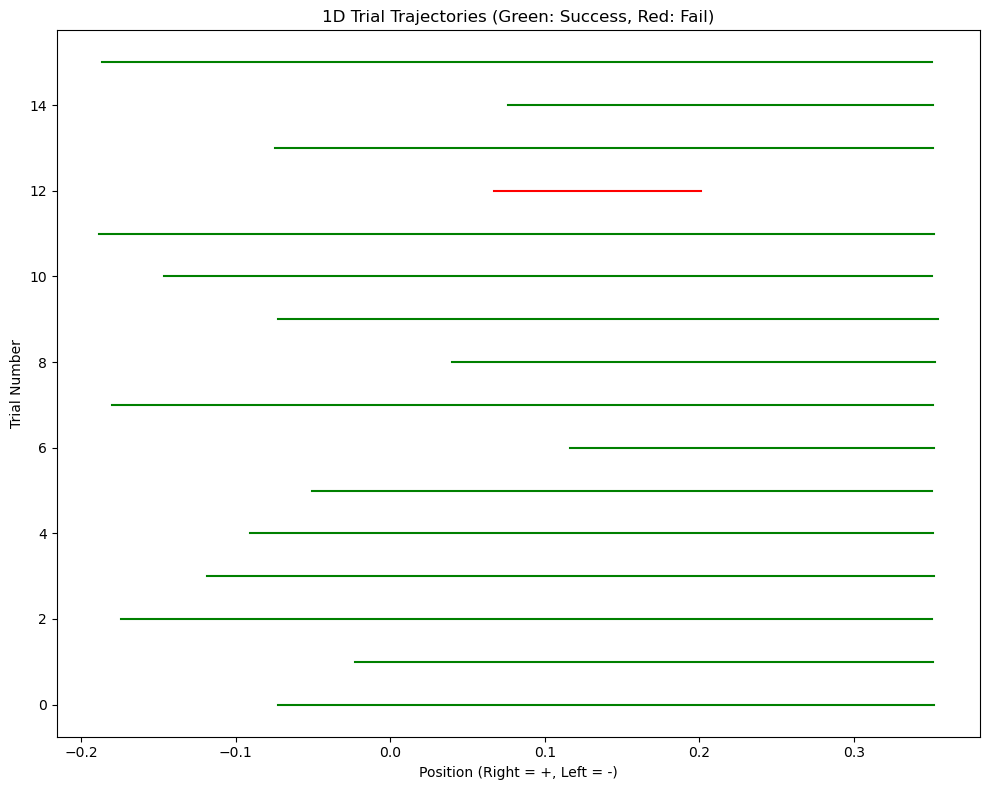

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the behavioral data
file_path = 'Behavioral data/Survey_Visual_2019-07-23-15-41-47.csv'
data = pd.read_csv(file_path, skiprows=1)
data.columns = data.columns.str.strip().str.lower()

# Convert trial to int and event to lowercase (standardize)
data['trial'] = data['trial'].astype(int)
data['event'] = data['event'].str.strip().str.lower()

# Ensure required columns exist
required_cols = ['trial', 'event', 'position']
if not all(col in data.columns for col in required_cols):
    raise ValueError("Missing one or more required columns: trial, event, position")

# Start plotting
plt.figure(figsize=(10, 8))
plt.title("1D Trial Trajectories (Green: Success, Red: Fail)")
plt.xlabel("Position (Right = +, Left = -)")
plt.ylabel("Trial Number")

trial_numbers = data['trial'].unique()
for i, trial_id in enumerate(trial_numbers):
    trial_data = data[data['trial'] == trial_id]

    events = trial_data['event'].values

    if 'target reached' in events:
        start_idx = trial_data[trial_data['event'] == 'control applied'].index.min()
        end_idx = trial_data[trial_data['event'] == 'target reached'].index.min()
        if pd.notna(start_idx) and pd.notna(end_idx) and end_idx > start_idx:
            traj = trial_data.loc[start_idx:end_idx, 'position']
            plt.plot(traj.values, [i]*len(traj), 'g-', linewidth=1.5)

    elif 'timeout start' in events:
        start_idx = trial_data[trial_data['event'] == 'control applied'].index.min()
        end_idx = trial_data[trial_data['event'] == 'timeout start'].index.min()
        if pd.notna(start_idx) and pd.notna(end_idx) and end_idx > start_idx:
            traj = trial_data.loc[start_idx:end_idx, 'position']
            plt.plot(traj.values, [i]*len(traj), 'r-', linewidth=1.5)

plt.tight_layout()
plt.show()
